# Keypoint Detection and Image Generation
HUANG Hejun (s1155135359)

* Presentation: 6:30pm, May 4. Each student has 2-3 minutes.

# Data

In [84]:
from google.colab import drive
drive.mount('/content/gdrive/')
ROOT_FOLDER = './gdrive/My Drive/Colab Notebooks/MAEG5735-2020-Assignment4/'

import glob
print('\nContents in the data folder:')
for x in glob.glob(ROOT_FOLDER+'data/*'):
    print(x)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).

Contents in the data folder:
./gdrive/My Drive/Colab Notebooks/MAEG5735-2020-Assignment4/data/imgs1.npy
./gdrive/My Drive/Colab Notebooks/MAEG5735-2020-Assignment4/data/imgs2.npy
./gdrive/My Drive/Colab Notebooks/MAEG5735-2020-Assignment4/data/kpts3.npy
./gdrive/My Drive/Colab Notebooks/MAEG5735-2020-Assignment4/data/kpts1.npy
./gdrive/My Drive/Colab Notebooks/MAEG5735-2020-Assignment4/data/README.txt


There should be 4 files:
* ```imgs1.npy```
* ```kpts1.npy```
* ```imgs2.npy```
* ```kpts3.npy```

(1000, 200, 200)
(1000, 9, 2)


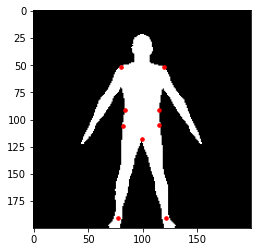

In [85]:
import matplotlib.pyplot as plt
import numpy as np

def draw_points(image, kpts):
    plt.figure()
    plt.imshow(image, cmap='gray')
    keypoints = (kpts+0.5)*IMG_SIZE
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=50, marker='.', c='r')

# load the data
IMG_SIZE = 200
IMG_TRAIN = np.load(ROOT_FOLDER+'data/imgs1.npy')
IMG_TRAIN = np.unpackbits(IMG_TRAIN).reshape((-1,IMG_SIZE,IMG_SIZE))
KPT_TRAIN = np.load(ROOT_FOLDER+'data/kpts1.npy')/IMG_SIZE - 0.5

IMG_TEST = np.load(ROOT_FOLDER+'data/imgs2.npy')
IMG_TEST = np.unpackbits(IMG_TEST).reshape((-1,IMG_SIZE,IMG_SIZE))

KPT_TEST = np.load(ROOT_FOLDER+'data/kpts3.npy')/IMG_SIZE - 0.5

# show one
idx = 10
draw_points(IMG_TRAIN[idx,:,:], KPT_TRAIN[idx,:,:])

print(np.shape(IMG_TRAIN))
print(np.shape(KPT_TRAIN))

# Task 1: Keypoint Detection


## Keypoints Dataset loader

In [0]:
import torch
from torch.utils.data import Dataset

class KeypointsDataset(Dataset):
    '''Keypoints Dataset'''
    def __init__(self, img, kpt, train=True, transform=None):
        self.img = img
        self.kpt = kpt
        self.train = train
        self.transform = transform
    
    def __len__(self):
        return self.img.shape[0]
    
    def __getitem__(self, idx):
        image = self.img[idx,:,:].astype(np.float32)
        if self.train:
            keypoints = self.kpt[idx,:,:].ravel().astype(np.float32)
        else:
            keypoints = None
        sample = {'image': image, 'keypoints': keypoints}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler

def prepare_train_valid_loaders(trainset, valid_size=0.2, 
                                batch_size=128):
    '''
    Split trainset data and prepare DataLoader for training and validation
    
    Args:
        trainset (Dataset): data 
        valid_size (float): validation size, defalut=0.2
        batch_size (int) : batch size, default=128
    ''' 
    
    # obtain training indices that will be used for validation
    num_train = len(trainset)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler)
    
    return train_loader, valid_loader

In [0]:
from torchvision import transforms
import cv2

class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        h, w = image.shape[:2]
        new_w = np.random.randint(w, self.output_size)
        new_h = new_w
        new_h, new_w = int(new_h), int(new_w)
        img = cv2.resize(image, (new_w, new_h))    
        if key_pts is not None:
            return {'image': img, 'keypoints': key_pts}
        else:
            return {'image': img}

class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        if h == new_h:
            return sample
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        #left = top # temp
        image = image[top: top + new_h,
                      left: left + new_w]
        if key_pts is not None:
            #key_pts = key_pts - [left/output_size, top/output_size]
            key_pts[0::2] = ((key_pts[0::2]+0.5)*w-left)/new_w-0.5
            key_pts[1::2] = ((key_pts[1::2]+0.5)*h-top)/new_h-0.5
            return {'image': image, 'keypoints': key_pts}
        else:
            return {'image': image}

class ToTensor(object):
    '''Convert ndarrays in sample to Tensors.'''
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.reshape(1, IMG_SIZE, IMG_SIZE)
        image = torch.from_numpy(image)
        if keypoints is not None:
            keypoints = torch.from_numpy(keypoints)
            return {'image': image, 'keypoints': keypoints}
        else:
            return {'image': image}


In [89]:
batch_size = 64
valid_size = 0.3 # percentage of training set to use as validation

# Define a transform to normalize the data
tsfm_train = transforms.Compose([Rescale(205), RandomCrop(200), ToTensor()])
tsfm_test = transforms.Compose([ToTensor()])

print(KPT_TRAIN.shape)
# Load the training data and test data of FRONT view
trainset_front = KeypointsDataset(IMG_TRAIN, KPT_TRAIN, transform=tsfm_train)
testset_front = KeypointsDataset(IMG_TEST, None, train=False, transform=tsfm_test)
                                 
# prepare data loaders for front view
train_loader_front, valid_loader_front = prepare_train_valid_loaders(trainset_front, valid_size, batch_size)
test_loader_front = torch.utils.data.DataLoader(testset_front, batch_size=batch_size)

(1000, 9, 2)


## Prediction model setting

### MLP model

In [0]:
from torch import nn, optim
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p =0.5):
        '''
        Buid a forward network with arbitrary hidden layers.
        Arguments
            ---------
            input_size (integer): size of the input layer
            output_size (integer): size of the output layer
            hidden_layers (list of integers):, the sizes of each hidden layers
        '''
        super(MLP, self).__init__()
        # hidden layers
        layer_sizes = [(input_size, hidden_layers[0])] \
                      + list(zip(hidden_layers[:-1], hidden_layers[1:]))
        self.hidden_layers = nn.ModuleList([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        self.output = nn.Linear(hidden_layers[-1], output_size)
        self.dropout = nn.Dropout(drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        # flatten inputs
        x = x.view(x.shape[0], -1)
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
            x = self.dropout(x)
        x = self.output(x)    
        return x

In [0]:
def train(train_loader, valid_loader, model, criterion, optimizer, 
          n_epochs=50, saved_model='model.pt'):
    '''
    Train the model
    
    Args:
        train_loader (DataLoader): DataLoader for train Dataset
        valid_loader (DataLoader): DataLoader for valid Dataset
        model (nn.Module): model to be trained on
        criterion (torch.nn): loss funtion
        optimizer (torch.optim): optimization algorithms
        n_epochs (int): number of epochs to train the model
        saved_model (str): file path for saving model
    
    Return:
        tuple of train_losses, valid_losses
    '''

    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf # set initial "min" to infinity

    train_losses = []
    valid_losses = []

    for epoch in range(n_epochs):
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device))
            # calculate the loss
            loss = criterion(output, batch['keypoints'].to(device))
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*batch['image'].size(0)

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for batch in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device))
            # calculate the loss
            loss = criterion(output, batch['keypoints'].to(device))
            # update running validation loss 
            valid_loss += loss.item()*batch['image'].size(0)

        # print training/validation statistics 
        # calculate average Root Mean Square loss over an epoch
        train_loss = np.sqrt(train_loss/len(train_loader.sampler.indices))
        valid_loss = np.sqrt(valid_loss/len(valid_loader.sampler.indices))

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'
              .format(epoch+1, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), saved_model)
            model_temp = model.state_dict()
            valid_loss_min = valid_loss
    return train_losses, valid_losses 

In [0]:
from torch import optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def predict(data_loader, model):
    '''
    Predict keypoints
    Args:
        data_loader (DataLoader): DataLoader for Dataset
        model (nn.Module): trained model for prediction.
    Return:
        predictions (array-like): keypoints in float (no. of images x keypoints).
    '''
    
    model.eval() # prep model for evaluation

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device)).cpu().numpy()
            if i == 0:
                predictions = output
            else:
                predictions = np.vstack((predictions, output))

    return predictions

### CNN model

In [0]:
class CNN(nn.Module):
      def __init__(self, output_size):
        super(CNN, self).__init__()
        # 200 x 200
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        # (w-f)/s+1 = 200
        self.pool1 = nn.MaxPool2d(4, 4)
        # 50
        self.conv2 = nn.Conv2d(32, 64, 3, padding=2)
        # (54-3)/1 + 1 = 52
        self.pool2 = nn.MaxPool2d(2, 2)
        # 26
        self.conv3 = nn.Conv2d(64, 128, 3)
        # (26-3)/1 + 1 = 24
        self.pool3 = nn.MaxPool2d(2, 2)
        # 12
        self.conv4 = nn.Conv2d(128, 256, 3, stride=2)
        # (12-3)/2 + 1 = 5
        self.conv5 = nn.Conv2d(256, 512, 1)
        # (5-1)/1+1 = 5
    
        # Fully Connected Layer
        self.fc1 = nn.Linear(512*5*5, 1024)
        self.fc2 = nn.Linear(1024, output_size)
        self.drop1 = nn.Dropout(p=0.1)
        self.drop2 = nn.Dropout(p=0.25)
        self.drop3 = nn.Dropout(p=0.25)
        self.drop4 = nn.Dropout(p=0.25)
        self.drop5 = nn.Dropout(p=0.35)
        self.drop6 = nn.Dropout(p=0.4)
    
      def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.drop1(x)
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.drop2(x)
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.drop3(x)
        x = F.relu(self.conv4(x))
        x = self.drop4(x)
        x = F.relu(self.conv5(x))
        x = self.drop5(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.drop6(x)
        x = self.fc2(x)
        return x

##Train the model using CNN

The following parameters are chosen:

*   Batch_size: 64
*   Valid spiltp: 3/7
*   Learning rate: 0.0005
*   Number of epochs: 220
*   With 5 conv-network and 2 full connect network and the matched parameters are shown above.

In [94]:
model_front = CNN(output_size=18)
model_front = model_front.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_front.parameters(), lr=0.0001)

train_losses, valid_losses = train(train_loader_front, valid_loader_front,
                   model_front, criterion, optimizer,
                   n_epochs=500,
                   saved_model=ROOT_FOLDER+'model_front.pt')

Epoch: 1 	Training Loss: 0.090174 	Validation Loss: 0.024724
Validation loss decreased (inf --> 0.024724).  Saving model ...
Epoch: 2 	Training Loss: 0.041324 	Validation Loss: 0.014640
Validation loss decreased (0.024724 --> 0.014640).  Saving model ...
Epoch: 3 	Training Loss: 0.036031 	Validation Loss: 0.016622
Epoch: 4 	Training Loss: 0.033536 	Validation Loss: 0.013995
Validation loss decreased (0.014640 --> 0.013995).  Saving model ...
Epoch: 5 	Training Loss: 0.032273 	Validation Loss: 0.015669
Epoch: 6 	Training Loss: 0.031027 	Validation Loss: 0.013902
Validation loss decreased (0.013995 --> 0.013902).  Saving model ...
Epoch: 7 	Training Loss: 0.030036 	Validation Loss: 0.015097
Epoch: 8 	Training Loss: 0.029699 	Validation Loss: 0.013928
Epoch: 9 	Training Loss: 0.029263 	Validation Loss: 0.014426
Epoch: 10 	Training Loss: 0.028350 	Validation Loss: 0.013540
Validation loss decreased (0.013902 --> 0.013540).  Saving model ...
Epoch: 11 	Training Loss: 0.028272 	Validation Lo

##Check the model prediction ability



In [0]:
# Evaluate this one
model_front.load_state_dict(torch.load(ROOT_FOLDER+'model_front.pt'))
KPT_PREDICT = predict(test_loader_front, model_front)

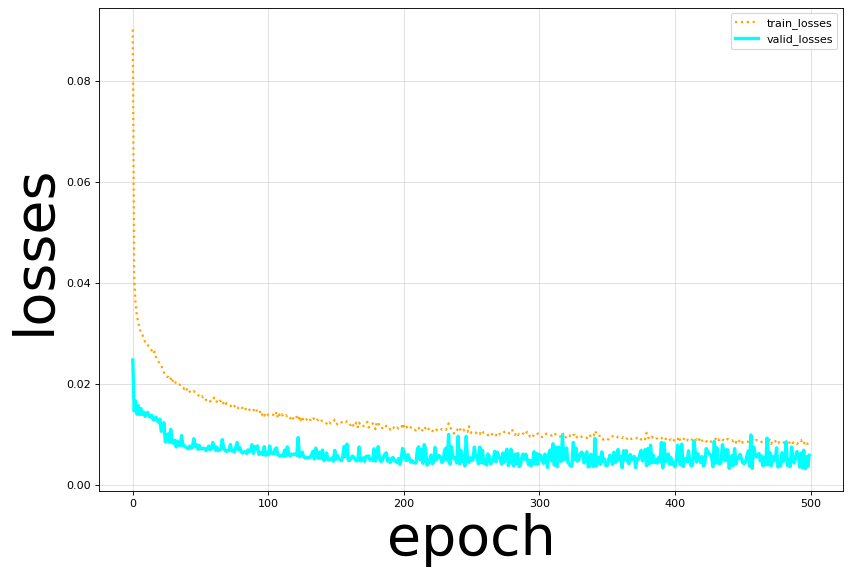

In [96]:
# Draw the changing curve
n_epochs=500
x=range(0,n_epochs)
plt.figure(figsize=(12,8),dpi=80)
y1=train_losses
y2=valid_losses
plt.grid(alpha=0.4)
plt.plot(x,y1,label='train_losses',color='orange',linestyle=":",linewidth=2)
plt.plot(x,y2,label='valid_losses',color='cyan',linestyle="-",linewidth=3)
plt.xlabel('epoch',size=50)
plt.ylabel('losses',size=50)
plt.legend()
plt.show()

9


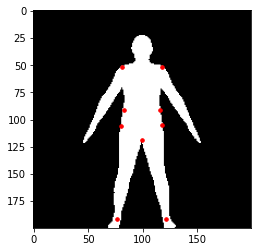

In [97]:
#Show one prediction
idx = np.random.randint(KPT_PREDICT.shape[0])
print(idx)
draw_points(IMG_TEST[idx,:,:], KPT_PREDICT[idx,:].reshape((-1,2)))

# Task 2: Image Generation
In the previous task, we predict low dimensional data (keypoints ```9x2```) from high dimensional input (images ```200x200```). Let's consider a different case now.

* Train a image generation model to predict silhouette images from keypoints.
  * Input: ```9x2``` keypoints coordinates
  * Output: corresponding sihouette images
* All of the available data can be used, including the keypoints you predicted on ```imgs2.npy``` in the previous task.
* Predict silhouett images for keypoints in ```kpts3.npy```.
  * Visualize the generated image together with input keypoints.

##Define the training function for task 2


In [0]:
def train_img(train_loader, valid_loader, model, criterion, optimizer, 
          n_epochs=50, saved_model='model.pt'):
    '''
    Train the model
    
    Args:
        train_loader (DataLoader): DataLoader for train Dataset
        valid_loader (DataLoader): DataLoader for valid Dataset
        model (nn.Module): model to be trained on
        criterion (torch.nn): loss funtion
        optimizer (torch.optim): optimization algorithms
        n_epochs (int): number of epochs to train the model
        saved_model (str): file path for saving model
    
    Return:
        tuple of train_losses, valid_losses
    '''

    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf # set initial "min" to infinity

    train_losses = []
    valid_losses = []

    for epoch in range(n_epochs):
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['keypoints'].to(device))
            # calculate the loss
            img = batch['image']
            img = img.reshape([len(img),40000])
            loss = criterion(output, img.to(device))
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*batch['keypoints'].size(0)

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for batch in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['keypoints'].to(device))
            # calculate the loss
            img2 = batch['image']
            img2 = img2.reshape([len(img2),40000])
            loss = criterion(output, img2.to(device))
            # update running validation loss 
            valid_loss += loss.item()*batch['keypoints'].size(0)

        # print training/validation statistics 
        # calculate average Root Mean Square loss over an epoch
        train_loss = np.sqrt(train_loss/len(train_loader.sampler.indices))
        valid_loss = np.sqrt(valid_loss/len(valid_loader.sampler.indices))

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'
              .format(epoch+1, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), saved_model)
            model_temp = model.state_dict()
            valid_loss_min = valid_loss
    return train_losses, valid_losses

##Train the model using MLP

The following parameters are chosen:



*   Learning rate: 0.001
*   Number of epochs: 150
*   Some pooling layers and convolutional layers in the CNN has been changed and can be found in the code.

In [131]:
device = torch.device('cuda' if torch.cuda.is_available() else 'CPU')
model_img = MLP(input_size=18, output_size=IMG_SIZE*IMG_SIZE, 
            hidden_layers=[64, 128], drop_p=0.1)
model_img = model_img.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_img.parameters(), lr=0.0001)
# optimizer = optim.SGD(model_img.parameters(), lr=0.001, momentum=0.95, weight_decay=1e-5)

train_losses, valid_losses = train_img(train_loader_front, valid_loader_front,
                  model_img, criterion, optimizer,
                  n_epochs=300,
                  saved_model=ROOT_FOLDER+'model_adjusted.pt')

Epoch: 1 	Training Loss: 0.382900 	Validation Loss: 0.380007
Validation loss decreased (inf --> 0.380007).  Saving model ...
Epoch: 2 	Training Loss: 0.379832 	Validation Loss: 0.377143
Validation loss decreased (0.380007 --> 0.377143).  Saving model ...
Epoch: 3 	Training Loss: 0.376955 	Validation Loss: 0.373940
Validation loss decreased (0.377143 --> 0.373940).  Saving model ...
Epoch: 4 	Training Loss: 0.373745 	Validation Loss: 0.370545
Validation loss decreased (0.373940 --> 0.370545).  Saving model ...
Epoch: 5 	Training Loss: 0.369799 	Validation Loss: 0.366022
Validation loss decreased (0.370545 --> 0.366022).  Saving model ...
Epoch: 6 	Training Loss: 0.364614 	Validation Loss: 0.360271
Validation loss decreased (0.366022 --> 0.360271).  Saving model ...
Epoch: 7 	Training Loss: 0.358361 	Validation Loss: 0.353355
Validation loss decreased (0.360271 --> 0.353355).  Saving model ...
Epoch: 8 	Training Loss: 0.350934 	Validation Loss: 0.344873
Validation loss decreased (0.35335

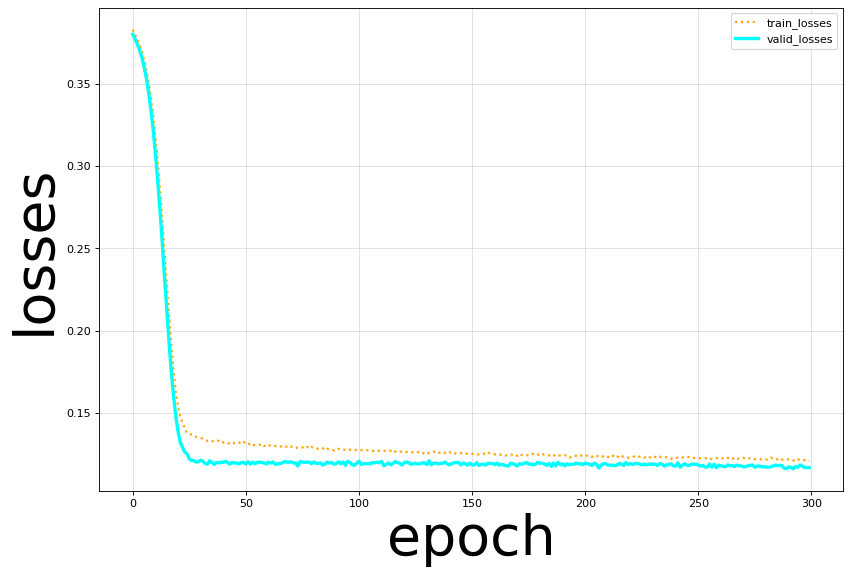

In [132]:
# Draw the changing curve
n_epochs=300
x=range(0,n_epochs)
plt.figure(figsize=(12,8),dpi=80)
y1=train_losses
y2=valid_losses
plt.grid(alpha=0.4)
plt.plot(x,y1,label='train_losses',color='orange',linestyle=":",linewidth=2)
plt.plot(x,y2,label='valid_losses',color='cyan',linestyle="-",linewidth=3)
plt.xlabel('epoch',size=50)
plt.ylabel('losses',size=50)
plt.legend()
plt.show()

##Define the prediction function and test dataloader for task 2


In [0]:
def predict_img(data_loader, model):
    '''
    Predict keypoints
    Args:
        data_loader (DataLoader): DataLoader for Dataset
        model (nn.Module): trained model for prediction.
    Return:
        predictions (array-like): keypoints in float (no. of images x keypoints).
    '''
    
    model.eval() # prep model for evaluation

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch.to(device)).cpu().numpy()
            if i == 0:
                predictions = output
            else:
                predictions = np.vstack((predictions, output))

    return predictions

In [0]:
class KeypointsDataset_kpt(Dataset):
    '''Keypoints Dataset'''
    def __init__(self, kpt, train=True, transform=None):
        self.kpt = kpt
        self.train = train
        self.transform = transform
    
    def __len__(self):
        return self.kpt.shape[0]
    
    def __getitem__(self, idx):
        keypoints = self.kpt[idx,:,:].ravel().astype(np.float32)
        sample = keypoints
        if self.transform:
            sample = self.transform(sample)
        return sample

class ToTensor(object):
    '''Convert ndarrays in sample to Tensors.'''
    def __call__(self, sample):
      if sample is not None:
        keypoints = torch.from_numpy(sample)
        return keypoints
      else:
        return 


##Load test data and predict the images for given keypoints

In [150]:
print(KPT_TEST.shape)
print(KPT_PREDICT.shape)
a=KPT_PREDICT.reshape((-1,9,2))
print(a.shape)

(100, 9, 2)
(1000, 18)
(1000, 9, 2)


In [0]:
tsfm_test_kpt = transforms.Compose([ToTensor()])

# Add the prediction result of the keypoints based on the imgs2
np.append(a,KPT_TEST)

testset_img = KeypointsDataset_kpt(KPT_TEST, train=False, transform=tsfm_test_kpt)
test_loader_img = torch.utils.data.DataLoader(testset_img, batch_size=batch_size)

model_img.load_state_dict(torch.load(ROOT_FOLDER+'model_adjusted.pt'))
IMG_PREDICT = predict_img(test_loader_img, model_img)

64


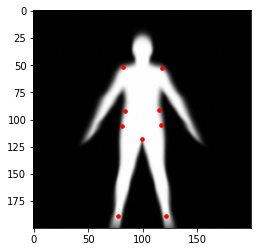

In [156]:
#Show one prediction
idx = np.random.randint(IMG_PREDICT.shape[0])
print(idx)
draw_points(IMG_PREDICT[idx,:].reshape(-1,200), KPT_TRAIN[idx,:,:])

# Conclusion

  
  During the assignment 4, I have learned a lot about the deep learning basic concepts including CNN structure, MLP structure. Now based on the assignment2, using the MLP method I have finished the image generation function even it is not a good solution to finish it. Maybe the random-forest is the best way to set up the prediction model with feature engineering based on assignment3 but we just have a week left, it is fine to finish the task in such a way.
 
  I have learned a lot in the MAEG5735 from Prof. Wang and TA. Liu, here to say thanks sincerely to them.

In [162]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcups2 libcupsfilters1 libcupsimage2 libgs9
  libgs9-common libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0
  libptexenc1 libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13
  lmodern poppler-data preview-latex-style rake ruby ruby-did-you-mean
  ruby-minitest ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto apache2 | lighttpd | httpd cups-common poppler-utils ghostscript
  fonts-japane

In [161]:
# Export the notebook as pdf
!sudo apt-get update

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [91.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:10 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:11 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:14 http://security.ubuntu.com/ubuntu bionic-security/main 

In [163]:
!jupyter nbconvert --to PDF "./gdrive/My Drive/Colab Notebooks/MAEG5735-2020-Assignment4/FinalAssignment_S1155135359.ipynb"

[NbConvertApp] Converting notebook ./gdrive/My Drive/Colab Notebooks/MAEG5735-2020-Assignment4/FinalAssignment_S1155135359.ipynb to PDF
[NbConvertApp] Support files will be in FinalAssignment_S1155135359_files/
[NbConvertApp] Making directory ./FinalAssignment_S1155135359_files
[NbConvertApp] Making directory ./FinalAssignment_S1155135359_files
[NbConvertApp] Making directory ./FinalAssignment_S1155135359_files
[NbConvertApp] Making directory ./FinalAssignment_S1155135359_files
[NbConvertApp] Making directory ./FinalAssignment_S1155135359_files
[NbConvertApp] Writing 164317 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: [u'bibtex', u'./notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 203548 bytes to ./gdrive/My Drive/Colab Notebooks/MAEG5735-2020-Ass